# A MODNet tutorial - Training the refractive index

This notebook goes trough the main functions and objects implemented by MODNet. Based on a dataset containing ~3,700 entries of type (mp_id, structure, refractive index) taken from the MaterialsProject (MP), a `MODNetModel` is trained. The workflow can be devided in two parts. First, the creation of a `MODData` object which stores the information concerning this particular dataset: the materials, the targets and optimal features. Second, a `MODNetModel` is trained which can later be used for predictions on unseen data.

In [1]:
# import dependencies
import sys
from modnet.models import MODNetModel
from modnet.preprocessing import MODData
import matplotlib.pyplot as plt

## 1. Loading the dataset

In this example the dataset is a dataframe saved as a pickle. But it can be any format as long as you can retreive the structures and targets (and the mpids optionally for fast featurization).

In [2]:
import pandas as pd
df = pd.read_pickle('data/df_ref.pkl')
print('{} datapoints'.format(len(df)))
df.head()

3735 datapoints


,structure,ref_index
mp-755998,[[2.06202807e-06 2.06349574e+00 2.69529553e+00...,2.439110
mp-13602,"[[0.97627791 4.96510018 6.65949814] O, [1.0206...",1.945601
mp-22467,"[[3.24119011 0.84967668 3.36565113] O, [3.2411...",2.283458
mp-23364,"[[1.23672715 1.23672715 0.81639113] Li, [3.710...",1.611454
mp-540621,"[[2.11356961 8.25584606 4.0428252 ] Sr, [6.474...",1.747648


Let's have a quick look at the dataset in terms of target distribution:

In [3]:
df.describe()

,ref_index
count,3735.000000
mean,1.956727
std,0.436022
min,1.236632
25%,1.658203
50%,1.890101
75%,2.138779
max,6.120923


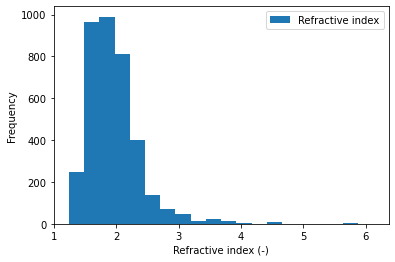

In [4]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["ref_index"], bins=20, density=False, label="Refractive index")
ax.set_ylabel("Frequency")
ax.set_xlabel("Refractive index (-)")
ax.legend()

## 2. Creating a MODData instance

### (a) structure, mpid, target creation

The first step is to gather all data in a `MODData` object. Here we put the structures, targets, ids, and property names.

In [5]:
md = MODData(materials = df['structure'],
             targets = df['ref_index'].values,
             structure_ids = df.index, #will be used to identify compounds
             target_names = ['refractive_index'] # you can choose any name
            )

2023-01-24 14:44:11,849 - modnet - INFO - Loaded Matminer2023Featurizer featurizer.


### (b) Featurizing the data
Structures wil be converted into features, using the matminer library. This can take some time. Fortunately, the MODData has an integrated database containing the features of many materials from the MP. By enabling fast featurization (`fast=True`) they are directly retreived from this database and not computed from the structure.

In [6]:
md.featurize(fast=True)

2023-01-24 14:44:11,892 - modnet - INFO - Computing features, this can take time...
2023-01-24 14:44:11,894 - modnet - INFO - Fast featurization on, retrieving from database...
2023-01-24 14:44:13,934 - modnet - INFO - Retrieved features for 3735 out of 3735 materials
2023-01-24 14:44:15,236 - modnet - INFO - Data has successfully been featurized!


In [7]:
md.get_featurized_df().head()

,AtomicOrbitals|HOMO_character,AtomicOrbitals|HOMO_element,AtomicOrbitals|HOMO_energy,AtomicOrbitals|LUMO_character,AtomicOrbitals|LUMO_element,AtomicOrbitals|LUMO_energy,AtomicOrbitals|gap_AO,AtomicPackingEfficiency|mean simul. packing efficiency,AtomicPackingEfficiency|mean abs simul. packing efficiency,AtomicPackingEfficiency|dist from 1 clusters |APE| < 0.010,...,BondFractions|Co - O bond frac.,BondFractions|Bi - O bond frac.,BondFractions|Sc - Sc bond frac.,BondFractions|Co - Co bond frac.,BondFractions|O - Y bond frac.,BondFractions|Nb - O bond frac.,CoulombMatrix|coulomb matrix eig 123,BondFractions|C - O bond frac.,BondFractions|Li - P bond frac.,SineCoulombMatrix|sine coulomb matrix eig 122
id,,,,,,,,,,,,,,,,,,,,,
mp-755998,2.0,7.0,-0.266297,1.0,40.0,-0.162391,0.103906,0.012571,0.012571,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mp-13602,2.0,8.0,-0.338381,2.0,8.0,-0.338381,0.000000,-0.020275,0.026709,0.015990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mp-22467,2.0,8.0,-0.338381,2.0,8.0,-0.338381,0.000000,-0.025676,0.025813,0.024296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mp-23364,2.0,17.0,-0.320380,1.0,3.0,-0.105540,0.214840,0.000000,0.000000,0.612372,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mp-540621,2.0,8.0,-0.338381,2.0,8.0,-0.338381,0.000000,-0.001310,0.050161,0.024298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### (c) Computing the optimal features

This runs the feature selection algorithm. First, the mutual information is computed, followed by the iterative selection based on relevance and redundancy.

This step takes a little bit of time, but is normally run only once before being saved.

Here, we use the precomputed cross-NMI, which corresponds to the NMI *between* features. This can either be run on the current dataset (`use_precomputed_cross_nmi=True`) or retreived from modnet itself as computed from a large set of data (`use_precomputed_cross_nmi=True`).
We use the second option as it is faster. However, it will warn you that some features are not in the precomputed cross-NMI. This is normal as the dataset may contain more complex structures than used in the precomputed file. For simplicity of the tutorial (and even in most cases), it can be ignored.

In [8]:
md.feature_selection(n=200,
                    n_samples=500,
                    use_precomputed_cross_nmi=True,
                    ) # Here we use precomputed cross_nmi to save time

2023-01-24 14:44:15,437 - modnet - INFO - Loading cross NMI from 'Features_cross' file.
2023-01-24 14:44:15,493 - modnet - WARNING - Feature mismatch between precomputed `Features_cross` and `df_featurized`. Missing columns: {'CoulombMatrix|coulomb matrix eig 121', 'SineCoulombMatrix|sine coulomb matrix eig 50', 'CoulombMatrix|coulomb matrix eig 33', 'SineCoulombMatrix|sine coulomb matrix eig 58', 'XRDPowderPattern|xrd_116', 'SineCoulombMatrix|sine coulomb matrix eig 42', 'SineCoulombMatrix|sine coulomb matrix eig 26', 'CoulombMatrix|coulomb matrix eig 14', 'CoulombMatrix|coulomb matrix eig 13', 'SineCoulombMatrix|sine coulomb matrix eig 114', 'CoulombMatrix|coulomb matrix eig 55', 'SineCoulombMatrix|sine coulomb matrix eig 77', 'CoulombMatrix|coulomb matrix eig 61', 'CoulombMatrix|coulomb matrix eig 96', 'BondFractions|Ta - Ta bond frac.', 'BondFractions|Y - Y bond frac.', 'XRDPowderPattern|xrd_90', 'XRDPowderPattern|xrd_42', 'SineCoulombMatrix|sine coulomb matrix eig 76', 'CoulombMat

We can now look at the most important features. This can be done by either looking at *relevant* features (highest target NMI) or *Relevant-nonRedundant (RR)* features.

In [9]:
# relevant features
md.target_nmi.nlargest(n=10)

DensityFeatures|density                         0.103335
ValenceOrbital|frac p valence electrons         0.087323
ElementProperty|MagpieData maximum GSbandgap    0.081005
ElementProperty|MagpieData range GSbandgap      0.080530
ElementProperty|MagpieData mean NdValence       0.080490
ElementProperty|MagpieData mean AtomicWeight    0.079362
ValenceOrbital|avg d valence electrons          0.078763
ElementProperty|MagpieData mean Number          0.077673
ElementProperty|MagpieData mean Row             0.075266
ElementProperty|MagpieData avg_dev Number       0.075012
Name: refractive_index, dtype: float64

In [10]:
# Relevant-unRedundant (RR) features
md.get_optimal_descriptors()[:10]

['DensityFeatures|density',
 'BondFractions|N - N bond frac.',
 'OPSiteFingerprint|std_dev pentagonal planar CN_5',
 'ElementProperty|MagpieData mode GSbandgap',
 'ElementProperty|MagpieData avg_dev Number',
 'AGNIFingerPrint|std_dev AGNI dir=x eta=1.23e+00',
 'ElementProperty|MagpieData maximum NdValence',
 'ElementProperty|MagpieData range Column',
 'OPSiteFingerprint|std_dev sgl_bd CN_1',
 'AGNIFingerPrint|mean AGNI eta=1.23e+00']

### (d) Saving the MODData

In [11]:
md.save('out/ref_index.mdt')

2023-01-24 14:45:58,449 - modnet - INFO - Data successfully saved as out/ref_index.mdt!


## 3. MODNet model
The previously created MODData is loaded:

In [12]:
md = MODData.load('out/ref_index.mdt')

2023-01-24 14:46:00,153 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7fa1643f7e50> object, created with modnet version 0.2.0~develop


### (a) Creating the `MODNetModel`

In [13]:
model = MODNetModel([[['refractive_index']]],{'refractive_index':1},
                    n_feat=200, # number of optimal features to use
                    num_neurons=[[128],[64],[32],[]], # architecture of the neural network
                    act='elu'
                   )
model.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 refractive_index (Dense)    (None, 1)                 33        
                                                                 
Total params: 36,097
Trainable params: 36,097
Non-trainable params: 0
_________________________________________________________________


2023-01-24 14:46:00.252445: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### (b) Training the model

Here the user provides hand-chosen hyperparameters and calls fit to train the model.

In [14]:
model.fit(md,val_fraction=0.1,
          val_key='refractive_index',
          loss='mae', lr=0.001, epochs = 300,
          batch_size = 64, xscale='minmax',
          yscale=None,
          verbose=1
         )

/Users/ppdebreuck/anaconda3/envs/modnet-develop/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


epoch 0: loss: 0.296, val_loss:0.149 val_mae:0.149
epoch 1: loss: 0.139, val_loss:0.152 val_mae:0.152
epoch 2: loss: 0.131, val_loss:0.117 val_mae:0.117
epoch 3: loss: 0.112, val_loss:0.107 val_mae:0.107
epoch 4: loss: 0.105, val_loss:0.109 val_mae:0.109
epoch 5: loss: 0.101, val_loss:0.102 val_mae:0.102
epoch 6: loss: 0.102, val_loss:0.135 val_mae:0.135
epoch 7: loss: 0.105, val_loss:0.108 val_mae:0.108
epoch 8: loss: 0.091, val_loss:0.091 val_mae:0.091
epoch 9: loss: 0.095, val_loss:0.121 val_mae:0.121
epoch 10: loss: 0.097, val_loss:0.090 val_mae:0.090
epoch 11: loss: 0.093, val_loss:0.091 val_mae:0.091
epoch 12: loss: 0.087, val_loss:0.082 val_mae:0.082
epoch 13: loss: 0.079, val_loss:0.104 val_mae:0.104
epoch 14: loss: 0.081, val_loss:0.077 val_mae:0.077
epoch 15: loss: 0.077, val_loss:0.075 val_mae:0.075
epoch 16: loss: 0.074, val_loss:0.081 val_mae:0.081
epoch 17: loss: 0.083, val_loss:0.088 val_mae:0.088
epoch 18: loss: 0.078, val_loss:0.080 val_mae:0.080
epoch 19: loss: 0.075,

We fit the model a second time with a lower learning rate to fine-tune the model

In [15]:
# we fit a secno
model.fit(md,
          val_fraction=0.1,
          val_key='refractive_index',
          lr=0.0005,
          epochs = 100,
          batch_size = 128,
          xscale='minmax',
          yscale=None,
          verbose=1
         )

/Users/ppdebreuck/anaconda3/envs/modnet-develop/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


epoch 0: loss: 0.002, val_loss:0.020 val_mae:0.058
epoch 1: loss: 0.002, val_loss:0.019 val_mae:0.056
epoch 2: loss: 0.001, val_loss:0.020 val_mae:0.056
epoch 3: loss: 0.002, val_loss:0.019 val_mae:0.055
epoch 4: loss: 0.001, val_loss:0.019 val_mae:0.055
epoch 5: loss: 0.001, val_loss:0.020 val_mae:0.056
epoch 6: loss: 0.001, val_loss:0.019 val_mae:0.054
epoch 7: loss: 0.001, val_loss:0.020 val_mae:0.058
epoch 8: loss: 0.002, val_loss:0.020 val_mae:0.056
epoch 9: loss: 0.002, val_loss:0.019 val_mae:0.058
epoch 10: loss: 0.002, val_loss:0.018 val_mae:0.054
epoch 11: loss: 0.001, val_loss:0.019 val_mae:0.055
epoch 12: loss: 0.001, val_loss:0.019 val_mae:0.056
epoch 13: loss: 0.001, val_loss:0.018 val_mae:0.055
epoch 14: loss: 0.001, val_loss:0.019 val_mae:0.055
epoch 15: loss: 0.001, val_loss:0.019 val_mae:0.056
epoch 16: loss: 0.001, val_loss:0.019 val_mae:0.056
epoch 17: loss: 0.001, val_loss:0.018 val_mae:0.055
epoch 18: loss: 0.001, val_loss:0.019 val_mae:0.059
epoch 19: loss: 0.002,

## 4. Saving the model

In [16]:
model.save('out/MODNet_refractive_index')

2023-01-24 14:46:37,092 - modnet - INFO - Model successfully saved as out/MODNet_refractive_index!


## 5. Predicting on unseen data

See "2-predicting_ref_index" notebook.